# Freesound Audio Tagging 2019 [(kaggle)](https://www.kaggle.com/c/freesound-audio-tagging-2019/)

- マルチラベルのオーディオタグ付けの問題
- Freesound（MTG-UPFによるイニシアチブで、400,000以上のクリエイティブ・コモンズ・ライセンス・サウンドの共同データベースを維持している）とGoogle ResearchのMachine Perceptionチーム（500以上のクラスを持つ手動アノテーションされたオーディオイベントの大規模データセット「AudioSet」の作成者）が協力して、この新しいコンペティションのデータセットを開発した
- 80のカテゴリーからなる多様な語彙を用いてオーディオデータに自動的にタグ付けするアルゴリズムの開発をねらう



## 概要
- https://arxiv.org/pdf/1906.02975.pdf


## Gold medals solution

- https://www.kaggle.com/c/freesound-audio-tagging-2019/discussion/97834
- [1位のコード：Ruslan Baikulov](https://github.com/lRomul/argus-freesound)

# 機械学習の前提知識

## k分割交差検証

### ホールドアウト法

データセットを学習用と評価用に分けて、モデルのトレーニングを行うこと。モデルのパラメータ調整に毎回評価用データを使用していると、その評価用データに特化したパラメータセットになってしまうため、結果的に未知のデータに対して性能が悪くなる可能性がある（過学習）。どのように分割するかで性能も変わるし、よろしくはない。そこでこのホールドアウト法を何回も繰り返す、k分割交差検証が一般的には用いられる。

### 概要

元のデータセットを学習・評価用に分け、そこから学習用データセットをさらにk分割（例えば10分割）する。そのうち９個は学習用、残りは評価用、という流れを合計10回繰り返していく。こうすることで、ホールドアウト法を単体で使用するより、様々な評価データでモデルを評価することが可能となり、より汎化性能が高いモデルの構築が可能となる。

## 標準化

データの大小だけで識別させたくない場合、データの値を `[0, 1]` に収まるようにスケールすることを標準化という。標準化ではデータセットの平均が0、分散が1になるように調整する。

# 前処理

## サンプリング

### trim

前後の無音部分を削除する。閾値として引数 `top_db=60` がデフォルト（60dB以下を無音とみなす）である。

```python
librosa.effects.trim(y)
```

### padding

最小サンプリング数を事前に定義しておき、トリムしたあとにそれを下回ると、元の音声データから（無音が入っているかもしれないが）いくらか長めに切り出す。それでも短かったら、0パディングする。


### 長さを揃える

- 音声処理として：データ0秒から規定の長さまで切り出す（短いデータは0埋めする）
- 画像処理として：ランダムに規定の次元数までクロッピングする


## 対数メルスペクトログラム

DNNで使用する特徴量として主流なのが、この対数メルスペクトログラムである。画像情報として取り扱うことで、画像認識技術でよく使用される data augmentation を流用することができるので良いらしい。
また、以下の図の３番目に示すような手法を取ることで、適宜自分の好きな領域を切り出すことができる。

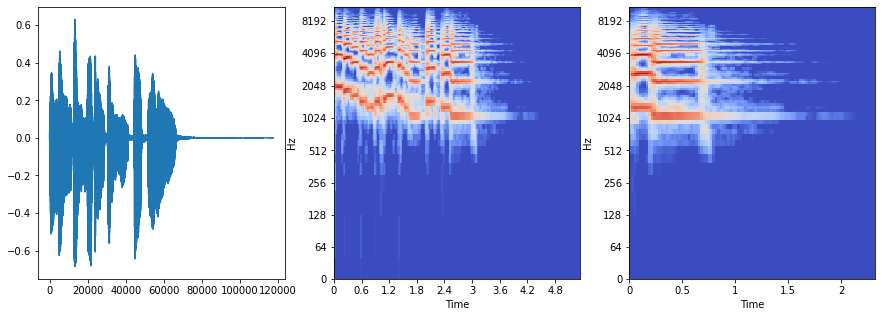

In [24]:
import librosa
from librosa import display
import matplotlib.pyplot as plt

y, sr = librosa.load(librosa.ex("trumpet"))
mel = librosa.feature.melspectrogram(y)
mel_db = librosa.power_to_db(mel)

fig, ax = plt.subplots(1,3,figsize=(15, 5))
ax[0].plot(y)
librosa.display.specshow(mel_db, x_axis="time", y_axis="log", ax=ax[1])
librosa.display.specshow(mel_db[:, 100:200], x_axis="time", y_axis="log", ax=ax[2])
plt.show()

## size
得られる対数メルスペクトログラムのサイズ。第一成分は周波数方向のビン数、第２成分は時間軸方向のビン数を表す。デフォルトでは `shape[0]` は128固定であるが、引数で変更することもできる。

In [21]:
print("shape : ", mel.shape)

shape :  (128, 230)


# モデル

## BasicConv2d 

使用された `BasicConv2d` は `nn.Conv2D` + `nn.BatchNorm2d` + `nn.ReLU` である。


### nn.Conv2D

- https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

```python
torch.nn.Conv2d(
    in_channels,    # 入力イメージのチャンネル数
    out_channels,  # 出力のチャンネル数
    kernel_size,     # カーネルサイズ
    stride,             # ストライド (default: 1)
    padding,          # 何でpaddingするか（default: 0)
    dilation
    ...
)
```

チャンネルとは例えば画像認識なら、画像の枚数のこと。出力の畳込み層種類分だけ重み行列があって、それを入力にかけて足し合わせ一枚の出力を作成する。

$$
\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
\sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
$$



- 5 random folds
- Loss: BCE on curated, Lsoft [3] with beta 0.7 on noisy data
- Optimizer: Adam with initial LR 0.0009
- LR scheduler: Reduce on a plateau with patience 6, factor 0.6
- Use different probabilities for sampling curated and noisy data
- Training on hand relabeled curated samples with a low lwlrap score by previous models
- Training with BCE on noisy samples with a high lwlrap score by previous models
- Mixed precision training with apex.amp allows using batch size 128 with input size 256x128 px


- https://work-in-progress.hatenablog.com/entry/2018/12/29/200000

- https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data

# Data augmentation（データ水増し）

ここでは画像データに対するデータ水増し手法についてまとめる

- 色調、色彩の変換
- 回転、サイズの変換
- ノイズを乗せる、部分的に隠す（black patches)

## SpecAugment

音声データに対して使用される手法で、横軸に時間、縦軸に周波数を持った画像情報として扱うことを念頭においている（例えば対数メルスペクトログラム）。
- 時間方向にずらす
- ある周波数をマスク（物理的に隠す）
- ある時間帯の情報をマスク（物理的に隠す）

ということを行って、データをかさ増しする。簡単な実装は以下の通り：

- https://www.kaggle.com/davids1992/specaugment-quick-implementation



## mixup

２つのサンプル$(X_1, y_1), (X_2, y_2)$ を使って新たなデータセットである $(X_3, y_3)$を作成する手法

- https://arxiv.org/pdf/1710.09412.pdf

# argus-freesound 

FAT2019スコア1位の方のGitHub repository.

# Data augumentation

自分で実装している模様。発想自体は PyTorch の Compose と全く同じで、処理させたい手法をリストで与えると、画像に対してそれらを逐次的に適用していく。入力データは対数メルスペクトログラムの画像であり、時間軸方向は可変、周波数方向は固定（`n_mels=128`)であることに留意。


```python
size = 256
transforms = Compose([
    OneOf([
        PadToSize(size, mode='wrap'),
        PadToSize(size, mode='constant'),
    ], p=[wrap_pad_prob, 1 - wrap_pad_prob]),
    
    # (128, ?) のデータを (128, size=256) のサイズにクロッピングする
    RandomCrop(size),
    
    # ランダムにリサイズする
    UseWithProb(
        RandomResizedCrop(scale=resize_scale, ratio=resize_ratio),
        prob=resize_prob
    ),
    
    # SpecAugment を行う (time warping なし)
    UseWithProb(SpecAugment(num_mask=spec_num_mask,
                            freq_masking=spec_freq_masking,
                            time_masking=spec_time_masking), spec_prob),
    ImageToTensor()
])
```


## 処理概要

- OneOf : リストで与えられた処理を、`p` 引数に指定された確率でどちらか一方を選択する
- UseWithProb : 与えられた処理を、`p` 引数に指定された確率で使用するかどうかを決定する

### PadToSize 

- PadToSize : `size` になるようにパディングを行う（numpy.padのconstant, wrap）

```python
class PadToSize:
    def __init__(self, size, mode='constant'):
        assert mode in ['constant', 'wrap']
        self.size = size
        self.mode = mode

    def __call__(self, signal):
        # パディングで調整するサイズよりもそもそも大きい場合は、何もしない
        if signal.shape[1] < self.size:
            
            # 埋め合わせるべきサイズを計算
            # 時間方向にpadding (log-melspectrogram なので周波数方向は同じビン数）
            padding = self.size - signal.shape[1]
            offset = padding // 2
            pad_width = ((0, 0), (offset, padding - offset))
            
            if self.mode == 'constant':
                signal = np.pad(signal, pad_width,
                                'constant', constant_values=signal.min())
            else:
                signal = np.pad(signal, pad_width, 'wrap')
        return signal
```

In [33]:
import numpy as np

y, sr = librosa.load(librosa.ex("trumpet"))
mel = librosa.feature.melspectrogram(y)
signal_orig = librosa.power_to_db(mel)
signal = librosa.power_to_db(mel)

padding = 300 - signal.shape[1]
offset = padding//2
pad_width = ((0,0), (offset, padding - offset))

signal = np.pad(signal, pad_width, 'constant', constant_values=signal.min())

print(signal_orig.shape, "---->", signal.shape)

(128, 230) ----> (128, 300)


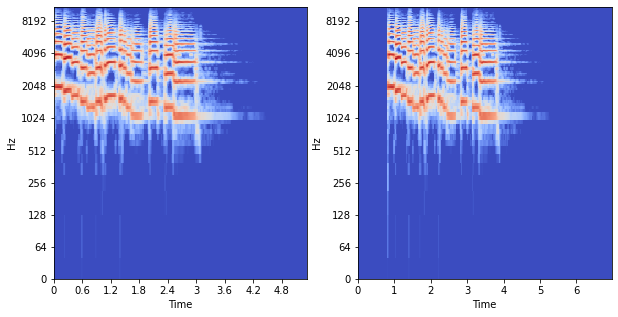

In [32]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
librosa.display.specshow(signal_orig, x_axis='time', y_axis='log', ax=ax[0])
librosa.display.specshow(signal, x_axis='time', y_axis='log', ax=ax[1])
plt.show()

### numpy.pad について

In [45]:
x_2d = np.arange(1, 3*3 + 1).reshape(3, 3)
print(x_2d)

print("\n 行方向に (1,1) ずつpadding + 列方向に (2,2) ずつpadding")
print(np.pad(x_2d, ((1, 1), (2, 2))))
#print(np.pad(x_2d, ((2, 2), (1, 1))))
#print(np.pad(x_2d, ((1, 2), (1, 2))))
#print(np.pad(x_2d, ((2, 1), (1, 2))))

print("\n 行方向に (1,1) ずつpadding + 列方向にも同様")
print(np.pad(x_2d, ((1, 1),)))
#print(np.pad(x_2d, ((1, 2),)))
#print(np.pad(x_2d, ((2, 1),)))
#print(np.pad(x_2d, ((2, 2),)))

print("\n 行方向に (1,1) ずつpadding + 列方向にも同様")
print(np.pad(x_2d, (1,)))
#print(np.pad(x_2d, (2,)))

[[1 2 3]
 [4 5 6]
 [7 8 9]]

 行方向に (1,1) ずつpadding + 列方向に (2,2) ずつpadding
[[0 0 0 0 0 0 0]
 [0 0 1 2 3 0 0]
 [0 0 4 5 6 0 0]
 [0 0 7 8 9 0 0]
 [0 0 0 0 0 0 0]]

 行方向に (1,1) ずつpadding + 列方向にも同様
[[0 0 0 0 0]
 [0 1 2 3 0]
 [0 4 5 6 0]
 [0 7 8 9 0]
 [0 0 0 0 0]]

 行方向に (1,1) ずつpadding + 列方向にも同様
[[0 0 0 0 0]
 [0 1 2 3 0]
 [0 4 5 6 0]
 [0 7 8 9 0]
 [0 0 0 0 0]]
